In [ ]:
!pip install lightkurve
!pip install batman-package
!pip install pandas
!pip install lmfit

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.6/997.6 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 55.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=a4093c497724afd3529a2de56a52b616b6a747e613f0017458a6742fc74c7dbb
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5

# **Planet B**

Mounted at /content/drive


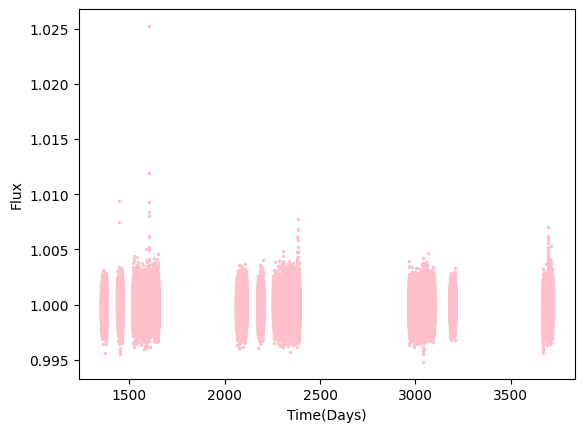

In [ ]:
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

search_result = lk.search_lightcurve('TIC 307210830',exptime = 120, author = 'SPOC')
lc_collection = search_result.download_all(quality_bitmask='hardest')
lcu = lc_collection.stitch().remove_nans()

new_flux = lcu.flux.value
new_flux = np.ma.filled(new_flux, fill_value=np.nan)
new_time = lcu.time.value
new_error = lcu.flux_err.value
new_error = np.ma.filled(new_error, fill_value=np.nan)


new_array = [new_time, new_flux, new_error]


np.savetxt('new_array.txt', np.column_stack((new_time, new_flux, new_error)), delimiter = ',', header = 'time,flux,flux_err', comments = '')

plt.scatter(new_time, new_flux, zorder = 10, color = 'pink', s = 2)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()

In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 3.69066906690669 , vary = True, min = 3.68, max =3.70)
paramslm.add('m', value = 0.273 , vary = False)
paramslm.add('w', value = 261, vary = False)
paramslm.add('rpl',value = 1.4 , vary = True, min =1.3 , max = 1.6 )
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.11 , vary = False )
paramslm.add('ecc', value =0.115, vary = True, min = 0.09, max = 0.12)
paramslm.add('t0', value = 1356.20231 , vary = True, min = 1356.2, max = 1356.21)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_function(paramslm, new_time, error, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 261.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, new_time)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`period` contains 212329 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


In [ ]:

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2175,2185)
plt.ylim(0.995,1.005)
#plt.savefig('3_Transits_of_Planet_B.png')
plt.show()

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2179,2179.5)
plt.ylim(0.995,1.005)
#plt.savefig('1_Transit_of_Planet_B_Zoomed_in.png')
plt.show()

In [ ]:
out = minimize(model_function, paramslm, args=(new_time, new_error), kws={'data': new_flux}, nan_policy='omit')
print(fit_report(out))


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3359
    # data points      = 336256
    # variables        = 4
    chi-square         = 0.22082144
    reduced chi-square = 6.5671e-07
    Akaike info crit   = -4786942.15
    Bayesian info crit = -4786899.25
[[Variables]]
    t:    3.69066741 +/- 4.9180e-07 (0.00%) (init = 3.690669)
    m:    0.273 (fixed)
    w:    261 (fixed)
    rpl:  1.47058905 +/- 0.00919335 (0.63%) (init = 1.4)
    rs:   0.303 (fixed)
    inc:  88.11 (fixed)
    ecc:  0.09000000 +/- 0.01003352 (11.15%) (init = 0.115)
    t0:   1356.20432 +/- 1.4425e-04 (0.00%) (init = 1356.202)
[[Correlations]] (unreported correlations are < 0.100)
    C(t, t0)    = -0.8306
    C(rpl, ecc) = -0.7557


In [ ]:
planet_b_model = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
planet_b_model.fold(period = out.params['t'].value, t0 = out.params['t0'].value ).scatter(c='pink', lw=1)
plt.xlim(-0.3,0.3)
plt.ylim(0.994,1.008)


In [ ]:

min_light_curveb = model_function(out.params, new_time, new_error)

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
#plt.xlim(1510,1530)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(1518,1527)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()



lcu_new = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
bin_lcu = lcu_new.bin(binsize = 10)

bin_lcu.scatter(color = 'pink')
plt.ylim(0.995,1.005)
plt.xlim(1643,1653)
plt.show()

bin_lcu.scatter(color = 'pink')
plt.plot(new_time,min_light_curveb , zorder = 10, color = 'crimson')
plt.ylim(0.995,1.005)
plt.xlim(1643,1653)
plt.show()

In [ ]:
sorted = np.argsort(new_time)
new_time = new_time[sorted]
new_flux = new_flux[sorted]
new_error = new_error[sorted]

masked_fluxb = new_flux / min_light_curveb
masked_timeb = new_time / min_light_curveb
masked_errorb = new_error / min_light_curveb



lcu_new_masked = lk.LightCurve( time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
bin_lcu = lcu_new_masked.bin(binsize = 10)

plt.scatter(masked_timeb, masked_fluxb, zorder = 10, color = 'violet', s = 2)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()




In [ ]:
bin_lcu.scatter(color = 'darkmagenta')
#plt.xlim(1643,1648)
plt.xlabel('Time(Days)')
plt.show()

# **Planet C**

In [ ]:
from lmfit import minimize

sorted = np.argsort(new_time)
new_time = new_time[sorted]
new_flux = new_flux[sorted]
new_error = new_error[sorted]

masked_fluxb = new_flux / min_light_curveb
masked_timeb = new_time / min_light_curveb
masked_errorb = new_error / min_light_curveb

sorter_new = np.argsort(masked_timeb)
masked_timeb = masked_timeb[sorter_new]
masked_fluxb = masked_fluxb[sorter_new]
masked_errorb = masked_errorb[sorter_new]

In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 7.45094 , vary = True, min = 7.44, max =7.46)
paramslm.add('m', value = 0.303 , vary = False)
paramslm.add('w', value = 180, vary = False)
paramslm.add('rpl',value = 1.515, vary = True, min =1.4 , max = 1.6)
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.449 , vary = False )
paramslm.add('ecc', value =0.085, vary = True, min = 0.065, max = 0.095)
paramslm.add('t0', value = 1355.2574113410246, vary = True, min = 1352, max = 1358)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_functionc(paramslm, masked_timeb, masked_errorb, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 180.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, masked_timeb)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



In [ ]:
m_flux = model_functionc(paramslm, masked_timeb, masked_errorb)
plt.plot(masked_timeb, m_flux, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'violet', marker = '.', s = 4)
plt.xlim(2189.5,2190)
plt.ylim(0.995,1.004)
#plt.savefig('1_Transit_of_Planet_B_Zoomed_in.png')
plt.show()

m_flux = model_functionc(paramslm, masked_timeb, masked_errorb)
plt.plot(masked_timeb, m_flux, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'violet', marker = '.', s = 7)
plt.xlim(2174,2200)
plt.ylim(0.995,1.005)
#plt.savefig('3_Transits_of_Planet_B.png')
plt.show()

In [ ]:
out = minimize(model_functionc, paramslm, args=(masked_timeb, masked_errorb), kws={'data': masked_fluxb}, nan_policy='omit')
print(fit_report(out))

In [ ]:
planet_c_model = lk.LightCurve(time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
planet_c_model.fold(period = out.params['t'].value, t0 = out.params['t0'].value).scatter(c='violet', lw=1)
plt.ylim(0.995, 1.005)
plt.xlim(-1, 1)

In [ ]:

min_light_curvec = model_functionc(out.params, masked_timeb, masked_errorb)
plt.plot(masked_timeb, min_light_curvec, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'violet', marker = '.', s = 4)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()


lcu_new = lk.LightCurve( time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
bin_lcu = lcu_new.bin(binsize = 10)

bin_lcu.scatter(color = 'violet')
plt.xlim(2061,2070)
plt.show()

bin_lcu.scatter(color = 'violet')
plt.plot(masked_timeb,min_light_curvec , zorder = 10, color = 'darkmagenta')
plt.ylim(0.995,1.002)
plt.xlim(1643,1648)
plt.show()

# **Planet D**

In [ ]:
sorter_new = np.argsort(masked_timeb)
masked_timeb = masked_timeb[sorter_new]
masked_fluxb = masked_fluxb[sorter_new]
masked_errorb = masked_errorb[sorter_new]


masked_fluxc = masked_fluxb / min_light_curvec
masked_timec = masked_timeb / min_light_curvec
masked_errorc = masked_errorb / min_light_curvec

sorted_new = np.argsort(masked_timec)
masked_timec = masked_timec[sorted_new]
masked_fluxc = masked_fluxc[sorted_new]
masked_errorc = masked_errorc[sorted_new]

In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_d_period = bls.period_at_max_power
planet_d_t0 = bls.transit_time_at_max_power
planet_d_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 2.250125312531253 , vary = True, min = 2.24, max =2.26)
paramslm.add('m', value = 0.303 , vary = False)
paramslm.add('w', value = 192, vary = False)
paramslm.add('rpl',value = 1, vary = True, min =0.75 , max = 1.2)
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.449 , vary = False )
paramslm.add('ecc', value =0.9, vary = True, min = 0.8, max = 1.1)
paramslm.add('t0', value = 1354.8974113410245, vary = True, min = 1353, max = 1356)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_functiond(paramslm, masked_timec, masked_errorc, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 192.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, masked_timeb)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



In [ ]:
m_flux = model_functiond(paramslm, masked_timec, masked_errorc)
plt.plot(masked_timec, m_flux, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 4)
#plt.xlim(2064,2070)
plt.ylim(0.995,1.005)
#plt.savefig('1_Transit_of_Planet_B_Zoomed_in.png')
plt.show()


m_flux = model_functiond(paramslm, masked_timec, masked_errorc)
plt.plot(masked_timec, m_flux, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 7)
plt.xlim(2068,2070)
plt.ylim(0.995,1.005)
#plt.savefig('3_Transits_of_Planet_B.png')
plt.show()

In [ ]:
out = minimize(model_functiond, paramslm, args=(masked_timec, masked_errorc), kws={'data': masked_fluxc}, nan_policy='omit')
print(fit_report(out))

In [ ]:
planet_d_model = lk.LightCurve(time=masked_timec, flux = masked_fluxc,flux_err=masked_errorc)
planet_d_model.fold(period = out.params['t'].value, t0 = out.params['t0'].value).scatter(c='lightblue', lw=1)

plt.ylim(0.995,1.005)


In [ ]:

min_light_curved = model_functiond(out.params, masked_timec, masked_errorc)
plt.plot(masked_timec, min_light_curved, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 4)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.ylim(0.996,1.004)
plt.xlim(1600,1610)
plt.show()

lcu_new = lk.LightCurve( time=masked_timec, flux = masked_fluxc,flux_err=masked_errorc)
bin_lcu = lcu_new.bin(binsize = 10)

bin_lcu.scatter(color = 'teal')
plt.xlim(2060,2150)
plt.show()

bin_lcu.scatter(color = 'lightblue')
plt.plot(masked_timec,min_light_curved , zorder = 10, color = 'teal')
plt.ylim(0.996,1.004)
plt.xlim(1600,1605)
plt.show()

# **Week 7 Summary**
---

**What we did:**

* Monday session was a lot of debugging our errors finding the smallest error possible and noting why some weren't exactly the same as the known and accepted values. We noticed that one of our out parameters cells kept taking asignificant amount of time but due to us getting feedback on our preliminary report, we weren't ale to ask the questions needed.
* Myself and Jasmin realised that we sure if we both had the same graphs so we spent all of that session double checking if we did.
* We did run in to an issue of our out parameters taking a significant amount of time to be produced but we managed to sort that out with how we formatted our notebook and made sure every planet had its own variable for model function and time, flux and error variables.

---
**What is next:**

* While doing our double checking we also talked with Ebeth and Abi on wat we polan to do next and we figured that it would be ideal to find the equilibrium temperature of each planet. From this we will need the albedo of planet earth as our planets are most compareable to earth.
* There are multiple papers and equations that we will need to look at while we are sorting this out.
* We were also thinking of finding the density of all te planets, then we can categorize what types of planets they are and compare to our own. This loks back to our original motivation of habitability. From this we could plot a graph of all known planet masses and see where ours lies.

---
**Papers and Resources:**

* https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131

* https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html (has equations for effective temp)

* https://en.wikipedia.org/wiki/Planetary_equilibrium_temperature (possible formula on this website, yet to find out if it is the right one.)